# Youtube API Practice file

In [1]:
# import dependencies
import pandas as pd
import json
import requests
from googleapiclient.discovery import build
from config import api_key
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import re

In [2]:
youtube = build('youtube', 'v3', developerKey=api_key)

In [3]:
def channel_information_grabber(video_list, title):
    # create empty dataframe
    top_channels_df = pd.DataFrame()

    # for loop to get channel details
    for channel in video_list:
        response = youtube.channels().list(
            part=['snippet', 'statistics', 'topicDetails', 'contentDetails'],
            id=channel
        ).execute()
        # append response to dataframe
        top_channels_df = top_channels_df.append(response['items'], ignore_index=True)

    # seperate the snippet column into its own dataframe
    snippet_df = pd.json_normalize(top_channels_df['snippet'])
    snippet_df = snippet_df.drop(columns=['thumbnails.default.width', 'thumbnails.default.height', 'thumbnails.medium.url', 'thumbnails.medium.width', 'thumbnails.medium.height', 'thumbnails.high.url', 'thumbnails.high.width', 'thumbnails.high.height', 'localized.title', 'localized.description'])

    # seperate the statistics column into its own dataframe
    statistics_df = pd.json_normalize(top_channels_df['statistics'])

    # seperate the topicDetails column into its own dataframe
    topicDetails_df = pd.json_normalize(top_channels_df['topicDetails'])

    # seperate the contentDetails column into its own dataframe
    contentDetails_df = pd.json_normalize(top_channels_df['contentDetails'])

    top_channels_df = top_channels_df.merge(snippet_df, left_index=True, right_index=True)
    top_channels_df = top_channels_df.merge(statistics_df, left_index=True, right_index=True)
    top_channels_df = top_channels_df.merge(topicDetails_df, left_index=True, right_index=True)
    top_channels_df = top_channels_df.merge(contentDetails_df, left_index=True, right_index=True)
    
    # change data types
    top_channels_df['publishedAt'] = pd.to_datetime(top_channels_df['publishedAt'])
    top_channels_df['viewCount'] = top_channels_df['viewCount'].astype('int64')
    top_channels_df['subscriberCount'] = top_channels_df['subscriberCount'].astype('int64')
    top_channels_df['videoCount'] = top_channels_df['videoCount'].astype('int64')

    # Remove the url from Topic Categories
    # top_channels_df['topicCategories'] = top_channels_df['topicCategories'].str.replace('https://en.wikipedia.org/wiki/', '')
    
    # drop columns that are not needed
    top_channels_df = top_channels_df.drop(columns=['kind', 'etag', 'snippet', 'statistics', 'topicDetails', 'country', 'hiddenSubscriberCount', 'contentDetails', 'relatedPlaylists.likes'])

    # sort by view count
    top_channels_df = top_channels_df.sort_values(by='viewCount', ascending=False)

    # add 'title' column
    top_channels_df['title'] = title

    # export as csv
    top_channels_df.to_csv(f'{title}_df.csv', index=False)

    return top_channels_df

In [4]:
def get_50_videos(channel_id):
    # get most recent uploads
    response = youtube.channels().list(
        part=['contentDetails'],
        id=channel_id
    ).execute()

    # get the playlist id
    playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    # get the videos in the playlist
    response = youtube.playlistItems().list(
        part=['contentDetails'],
        playlistId=playlist_id,
        maxResults=50
    ).execute()

    # get the video ids
    video_ids = []
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    return video_ids

In [5]:
get_50_videos('UCbCmjCuTUZos6Inko4u57UQ')

['lmH5uqwaFq8',
 '0SY0Yn0yF9o',
 'sNyF7BvVfxs',
 'K4kqqCzF-BA',
 'gfZmvllWVwY',
 'Ay3m-zZ4KLs',
 'mbPNkDEN3Ps',
 'kSx1tS52ov4',
 'o3eMkWX8E7U',
 'o1YenjwOp-A',
 'hqFfJBOrvHw',
 'QYTYKUMOuwo',
 'biXYtxZnChQ',
 'tkTYVy5sdIg',
 '-4nWoQwSHGE',
 'zhoVe42Pxb0',
 'lkBlyggtYhA',
 '3rKIRUm5oV4',
 '3QFTTxD7SuY',
 'DqhH2OUOl1M',
 'SSe98txCv00',
 'uHJN15kVTLY',
 'zHvKlszHzCg',
 'dxjciWnjd0M',
 '3LEW8jG-Q5Y',
 'usqngNJYnug',
 '3e_KEVMUvuo',
 'NSlWgxDFbe8',
 'f_8Bce7Y_p4',
 'G_MubFgSHdI',
 '-BztdXchohU',
 'tztm8t46_hI',
 'ep2qRkyIjek',
 'GbRm5DFfl88',
 'Xxa-wbT93QU',
 'Xf4XemBwzDY',
 'dfRBIE3AE34',
 'LA2q3QwhG54',
 'FGcXy0MZ3Ys',
 'iWwDq7-TCo4',
 'j7DH5splyoY',
 'U5Inxa3jK0Y',
 'Zre4vqUAgHU',
 'hqzvHfy-Ij0',
 'LCwxpu1uV60',
 'Lig3cP174Jo',
 'uCNLiwNFvuc',
 'wwosJXWGWRY',
 'TF-RmVyoEbM',
 'FtAZUKtC0Fk']

In [6]:
def video_details_grabber(video_id):
    # get video title
    try:
        video_title = youtube.videos().list(part='snippet', id=video_id).execute()['items'][0]['snippet']['title']
        video_title_clean = ''.join(e for e in video_title if e.isalnum() or e == ' ')
        video_title_clean = video_title_clean.replace('  ', ' ')
    except:
        video_title_clean = 'None'

    # get video id
    try:
        video_id = youtube.videos().list(part='snippet', id=video_id).execute()['items'][0]['id']
    except:
        video_id = np.nan

    # get the date time the video was published
    try:
        video_published = youtube.videos().list(part='snippet', id=video_id).execute()['items'][0]['snippet']['publishedAt']
    except:
        video_published = None

    # get number of views
    try:
        video_views = youtube.videos().list(part='statistics', id=video_id).execute()['items'][0]['statistics']['viewCount']
    except:
        video_views = 0

    # is the video made for kids?
    try:
        video_madeforkids = youtube.videos().list(part='status', id=video_id).execute()['items'][0]['status']['madeForKids']
    except:
        video_madeforkids = False

    # get video description
    try:
        video_description = youtube.videos().list(part='snippet', id=video_id).execute()['items'][0]['snippet']['description']
    except:
        video_description = ''

    # get like count
    try:
        video_likes = youtube.videos().list(part='statistics', id=video_id).execute()['items'][0]['statistics']['likeCount']
    except:
        video_likes = 0

    # get nummber of comments
    try:
        video_comment_count = youtube.videos().list(part='statistics', id=video_id).execute()['items'][0]['statistics']['commentCount']
    except:
        video_comment_count = 0

    # get length of video
    try:
        video_length = youtube.videos().list(part='contentDetails', id=video_id).execute()['items'][0]['contentDetails']['duration']
        video_length = video_length.replace('PT', '')
        video_length = video_length.replace('H', ':')
        video_length = video_length.replace('M', ':')
        video_length = video_length.replace('S', '')
    except:
        video_length = None

    # retrieve youtube video results
    # video_response = youtube.commentThreads().list(part='snippet,replies', videoId=video_id).execute()

    # create empty dataframe
    df = pd.DataFrame(columns=[
        'video_title', 'video_id', 'published', 'video_views', 'video_madeforkids', 
        'video_likes', 'video_comment_count'])

    # append video details to dataframe
    df = df.append({
        'video_title': video_title_clean,
        'video_title_clean': video_title_clean,
        'video_id': video_id,
        'published': video_published,
        'video_views': video_views,
        'video_madeforkids': video_madeforkids,
        'video_likes': video_likes,
        'video_comment_count': video_comment_count,
        'video_length': video_length
    }, ignore_index=True)
    
    return df

In [7]:
top_channels = ['UCbCmjCuTUZos6Inko4u57UQ', 'UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UCX6OQ3DkcsbYNE6H8uQQuVA', 'UCk8GzjMOrta8yxDcKfylJYw', 'UCJplp5SjeGSdVdwsfb9Q7lQ', 
'UCJ5v_MCY6GNUBTO8-D3XoAg', 'UCvlE5gTbOvjiolFlEm-c_Ow', 'UC295-Dw_tDNtZXFeAPAW6Aw', 'UCIwFjwMjI0y7PDBVEO9-bkQ', 'UCcdwLMPsaU2ezNSJU1nFoBQ', 
'UCRijo3ddMTht_IHyNSNXpNQ', 'UC3gNmTGu-TTbFPpfSs5kNkg', 'UCfM3zsQsOnfWNUppiycmBuw', 'UC0C-w0YjGpqDXGB8IHb662A', 'UC9CoOnJkIBMdeijd9qYoT_g', 
'UC4NALVCmcmL5ntpV0thoH6w', 'UCqECaJ8Gagnn7YCbPEzWH6g', 'UCRx3mKNUdl8QE06nEug7p6Q', 'UCiGm_E4ZwYSHV3bcW1pnSeQ', 'UC4rlAVgAK0SGk-yTfe48Qpw']

In [8]:
top_education_channels = [
'UC1zZE_kJ8rQHgLTVfobLi_g', 
'UCpVm7bg6pXKo1Pr6k5kxG9A', 
'UCX6b17PVsYBQ0ip5gyeme-Q', 
'UCsooa4yRKGN_zEE8iknghZA',
'UCXhSCMRRPyxSoyLSPFxK7VA',
'UCGi_crMdUZnrcsvkCa8pt-g',
'UCZYTClx2T1of7BRZ86-8fow',
'UCHnyfMqiRRG1u-2MsSQLbXA',
'UCYenDLnIHsoqQ6smwKXQ7Hg',
'UC4a-Gbdw7vOaccHmFo40b9g']
top_cooking_channels = [
'UCJFp8uSYCjXOMnkUyb3CQ3Q',
'UCYjk_zY-iYR8YNfJmuzd70A',
'UCpSgg_ECBj25s9moCDfSTsA',
'UCsP7Bpw36J666Fct5M8u-ZA',
'UCJHA_jMfCvEnv-3kRjTCQXw', 
'UCNbngWUqL2eqRw12yAwcICg', 
'UC8gFadPgK2r1ndqLI04Xvvw', 
'UCRxAgfYexGLlu1WHGIMUDqw', 
'UCbpMy0Fg74eXXkvxJrtEn3w', 
'UCfyehHM_eo4g5JUyWmms2LA']
top_fitness_channels = [
'UCiP6wD_tYlYLYh3agzbByWQ',
'UCIJwWYOfsCfz6PjxbONYXSg', 
'UCM1Nde-9eorUhq-teaWlgUA', 
'UCBINFWq52ShSgUFEoynfSwg', 
'UCEtMRF1ywKMc4sf3EXYyDzw', 
'UCyqR7WkL8i1b6xtSssDmW9w', 
'UCGMOauU8dOd4mv2bT3Tx57w',
'UCEQi1ZNJiw3YMRwni0OLsTQ',
'UC4GJndVHEhdmqLFBHOCi97A', 
'UCiH4auDlkM0tgn9ewT3B1Vw']
top_history_channels = [
'UC9MAhZQQd9egwWCxrwSIsJQ', 
'UClfEht64_NrzHf8Y0slKEjw', 
'UC510QYlOlKNyhy_zdQxnGYw',
'UCNIuvl7V8zACPpTmmNIqP2A', 
'UCggHoXaj8BQHIiPmOxezeWA',
'UC88lvyJe7aHZmcvzvubDFRg',
'UCodbH5mUeF-m_BsNueRDjcw',
'UCv_vLHiWVBh_FR9vbeuiY-A',
'UCx-dJoP9hFCBloY9qodykvw',
'UCHdluULl5c7bilx1x1TGzJQ']
top_science_channels = [
'UCC552Sd-3nyi_tk2BudLUzA',
'UCsXVk37bltHxD1rDPwtNM8Q', 
'UC6107grRI4m0o2-emgoDnAA', 
'UCUHW94eEFW7hkUMVaZz4eDg', 
'UC06E4Y_-ybJgBUMtXx8uNNw', 
'UCmQXOAse-VnzuXHebX5I77g', 
'UCxo8ooAqXiObjuaIy10ud0A', 
'UCvJiYiBUbw4tmpRSZT2r1Hw', 
'UCJcycnanWtyOGcz34jUlYZA',
'UC9uD-W5zQHQuAVT2GdcLCvg']
top_news_channels = [
'UCn8zNIfYAQNdrFRrr8oibKw',
'UCttspZesZIDEwwpVIgoZtWQ',
'UCfwx98Wty7LhdlkxL5PZyLA',
'UCupvZG-5ko_eiXAupbDfxWw',
'UCLXo7UDZvByw2ixzpQCufnA',
'UCE2606prvXQc_noEqKxVJXA',
'UC9k-yiEpRHMNVOnOi_aQK8w',
'UCBi2mrWuNuyYy4gbM6fU18Q',
'UC1yBKRuGpC1tSM73A0ZjYjQ',
'UC16niRr50-MSBwiO3YDb3RA']
top_music_channels = [
'UC0C-w0YjGpqDXGB8IHb662A',
'UCfM3zsQsOnfWNUppiycmBuw',
'UCYvmuw-JtVrTZQ-7Y4kd63Q',
'UCqECaJ8Gagnn7YCbPEzWH6g',
'UCb2HGwORFBo94DmRx4oLzow',
'UC9CoOnJkIBMdeijd9qYoT_g',
'UCpDJl2EmP7Oh90Vylx0dZtA',
'UCa10nxShhzNrCE1o2ZOPztg',
'UCoUM-UJ7rirJYP8CQ0EIaHA',
'UCEdvpU2pFRCVqU6yIPyTpMQ']
top_comedy_channels = [
'UCY30JRSgfhYXA6i6xX1erWg',
'UCV9_KinVpV-snHe3C3n1hvA',
'UC9gFih9rw0zNCK3ZtoKQQyA',
'UC8-Th83bH_thdKZDJCrn88g',
'UCxSz6JVYmzVhtkraHWZC7HQ',
'UCfm4y4rHF5HGrSr-qbvOwOg',
'UCPDis9pjXuqyI7RYLJ-TTSA',
'UCB0d0JLn1WcGYcwwZ87d2LA',
'UCPDXXXJj9nax0fr0Wfc048g',
'UCi9cDo6239RAzPpBZO9y5SA']
top_travel_channels = [
'UCHJuQZuzapBh-CuhRYxIZrg',
'UCyEd6QBSgat5kkC6svyjudA',
'UCdPambxHRj0kdFPNoJFM98A',
'UCXsQlHGuoWqukC9vz-uonrg',
'UCd5xLBi_QU6w7RGm5TTznyQ',
'UCGaOvAFinZ7BCN_FDmw74fQ',
'UC8hI77bH0VraIw6p2PHwivQ',
'UC_ptyMRLOsS1Uj0a34a_xCA',
'UCJsSEDFFnMFvW9JWU6XUn0Q',
'UCchgIh8Tc4sTmBfnMQ5pDdg']


In [9]:
## Music topics
topicId_list = {
'/m/04rlf': 'Music',
'/m/05fw6t':   "Children's music",
'/m/02mscn':   "Christian music",
'/m/0ggq0m':   "Classical music",
'/m/01lyv':   "Country",
'/m/02lkt':   "Electronic music",
'/m/0glt670':    "Hip hop music",
'/m/05rwpb':   "Independent music",
'/m/03_d0':    "Jazz",
'/m/028sqc':   "Music of Asia",
'/m/0g293':   "Music of Latin America",
'/m/064t9':    "Pop music",
'/m/06cqb':   "Reggae",
'/m/06j6l':   "Rhythm and blues",
'/m/06by7':   "Rock music",
'/m/0gywn':   "Soul music",
'/m/0bzvm2':    "Gaming",
'/m/025zzc':    "Action game",
'/m/02ntfj':    "Action-adventure game",
'/m/0b1vjn':    "Casual game",
'/m/02hygl':    "Music video game",
'/m/04q1x3q':    "Puzzle video game",
'/m/01sjng':   "Racing video game",
'/m/0403l3g':    "Role-playing video game",
'/m/021bp2':    "Simulation video game",
'/m/022dc6':    "Sports game",
'/m/03hf_rm':    "Strategy video game",
'/m/06ntj':    "Sports",
'/m/0jm_':   "American football",
'/m/018jz':    "Baseball",
'/m/018w8':    "Basketball",
'/m/01cgz':    "Boxing",
'/m/09xp_':    "Cricket",
'/m/02vx4':    "Football",
'/m/037hz':    "Golf",
'/m/03tmr':    "Ice hockey",
'/m/01h7lh':    "Mixed martial arts",
'/m/0410tth':    "Motorsport",
'/m/066wd':    "Professional wrestling",
'/m/07bs0':    "Tennis",
'/m/07_53':   "Volleyball",
'/m/02jjt':    "Entertainment",
'/m/095bb':    "Animated cartoon",
'/m/09kqc':    "Humor",
'/m/02vxn':    "Movies",
'/m/05qjc':    "Performing arts",
'/m/019_rr':    "Lifestyle",
'/m/032tl':    "Fashion",
'/m/027x7n':    "Fitness",
'/m/02wbm':    "Food",
'/m/0kt51':    "Health",
'/m/03glg':    "Hobby",
'/m/068hy':    "Pets",
'/m/041xxh':    "Physical attractiveness [Beauty]",
'/m/07c1v':    "Technology",
'/m/07bxq':    "Tourism",
'/m/07yv9':    "Vehicles",
'/m/01k8wb':    "Knowledge",
'/m/098wr':    "Society"
}

In [10]:
channel_information_grabber(top_channels, 'top_channels')

,id,title,description,customUrl,publishedAt,thumbnails.default.url,defaultLanguage,viewCount,subscriberCount,videoCount,topicIds,topicCategories,relatedPlaylists.uploads
0,UCbCmjCuTUZos6Inko4u57UQ,top_channels,"At CoComelon, our primary goal has always been...",@cocomelon,2006-09-01 22:18:49+00:00,https://yt3.ggpht.com/ytc/AMLnZu_BJeBKaLTt0S8I...,NaN,142468175305,146000000,811,"[/m/04rlf, /m/02vxn, /m/02jjt]","[https://en.wikipedia.org/wiki/Music, https://...",UUbCmjCuTUZos6Inko4u57UQ
4,UCJplp5SjeGSdVdwsfb9Q7lQ,top_channels,Welcome to Nastya's universe - where Nastya an...,@likenastyaofficial,2016-12-06 12:15:52+00:00,https://yt3.ggpht.com/ytc/AMLnZu82C2HA_T5m6zY8...,NaN,85153276697,102000000,728,"[/m/019_rr, /m/03glg]",[https://en.wikipedia.org/wiki/Lifestyle_(soci...,UUJplp5SjeGSdVdwsfb9Q7lQ
3,UCk8GzjMOrta8yxDcKfylJYw,top_channels,"Welcome to Diana and Roma world - where Diana,...",@kidsdianashow,2015-05-12 08:26:57+00:00,https://yt3.ggpht.com/ytc/AMLnZu9RnORdVDP9G2zT...,ru,83269659406,102000000,1030,"[/m/019_rr, /m/03glg]",[https://en.wikipedia.org/wiki/Lifestyle_(soci...,UUk8GzjMOrta8yxDcKfylJYw
5,UCJ5v_MCY6GNUBTO8-D3XoAg,top_channels,WWE on YouTube is your number one spot to catc...,@wwe,2007-05-11 01:20:02+00:00,https://yt3.ggpht.com/ytc/AMLnZu9vy3-XIqwir99c...,NaN,72205516440,91600000,64793,"[/m/066wd, /m/05qjc, /m/02jjt, /m/06ntj, /m/01...",[https://en.wikipedia.org/wiki/Professional_wr...,UUJ5v_MCY6GNUBTO8-D3XoAg
6,UCvlE5gTbOvjiolFlEm-c_Ow,top_channels,“Vlad & Niki” is the global preschool phenomen...,@vladandniki,2018-04-23 13:58:18+00:00,https://yt3.ggpht.com/RlnpUc0SBCmYvseTqUqAfYey...,NaN,69946638722,89200000,497,"[/m/019_rr, /m/03glg]",[https://en.wikipedia.org/wiki/Lifestyle_(soci...,UUvlE5gTbOvjiolFlEm-c_Ow
11,UC3gNmTGu-TTbFPpfSs5kNkg,top_channels,Rotten Tomatoes MOVIECLIPS is the largest coll...,@movieclips,2006-04-28 00:02:37+00:00,https://yt3.ggpht.com/QSCDnr5KmYElRp-zYpdW-txk...,NaN,59346610283,58100000,39625,"[/m/02vxn, /m/02jjt, /m/02ntfj]","[https://en.wikipedia.org/wiki/Film, https://e...",UU3gNmTGu-TTbFPpfSs5kNkg
9,UCcdwLMPsaU2ezNSJU1nFoBQ,top_channels,Welcome to Pinkfong's official YouTube channel...,@pinkfong,2011-12-14 04:54:24+00:00,https://yt3.ggpht.com/ytc/AMLnZu9IP3DGK7hqMHRP...,NaN,34102257505,61700000,2485,"[/m/02jjt, /m/02vxn, /m/04rlf]","[https://en.wikipedia.org/wiki/Entertainment, ...",UUcdwLMPsaU2ezNSJU1nFoBQ
15,UC4NALVCmcmL5ntpV0thoH6w,top_channels,LooLoo KIDS is all about the kids! The best En...,@loolookids,2014-08-05 20:15:33+00:00,https://yt3.ggpht.com/ytc/AMLnZu-U78x26u39WILK...,NaN,29999181826,51100000,576,"[/m/02jjt, /m/04rlf, /m/02vxn]","[https://en.wikipedia.org/wiki/Entertainment, ...",UU4NALVCmcmL5ntpV0thoH6w
8,UCIwFjwMjI0y7PDBVEO9-bkQ,top_channels,Help change the world. JUSTICE the album out n...,@justinbieber,2007-01-15 21:17:27+00:00,https://yt3.ggpht.com/ytc/AMLnZu-MPl6e5QKTWlsn...,NaN,29118070497,70400000,248,"[/m/04rlf, /m/064t9, /m/0glt670]","[https://en.wikipedia.org/wiki/Music, https://...",UUIwFjwMjI0y7PDBVEO9-bkQ
1,UC-lHJZR3Gqxm24_Vd_AJ5Yw,top_channels,I make videos.,@pewdiepie,2010-04-29 10:54:00+00:00,https://yt3.ggpht.com/5oUY3tashyxfqsjO5SGhjT4d...,NaN,28569722998,111000000,4514,"[/m/019_rr, /m/0bzvm2]",[https://en.wikipedia.org/wiki/Lifestyle_(soci...,UU-lHJZR3Gqxm24_Vd_AJ5Yw


In [11]:
channel_information_grabber(top_education_channels, 'top_education_channels')
channel_information_grabber(top_cooking_channels, 'top_cooking_channels')
channel_information_grabber(top_fitness_channels, 'top_fitness_channels')
channel_information_grabber(top_history_channels, 'top_history_channels')
channel_information_grabber(top_science_channels, 'top_science_channels')
channel_information_grabber(top_news_channels, 'top_news_channels')
channel_information_grabber(top_music_channels, 'top_music_channels')
channel_information_grabber(top_comedy_channels, 'top_comedy_channels')
channel_information_grabber(top_travel_channels, 'top_travel_channels')

,id,title,description,customUrl,publishedAt,thumbnails.default.url,defaultLanguage,viewCount,subscriberCount,videoCount,topicIds,topicCategories,relatedPlaylists.uploads
0,UCHJuQZuzapBh-CuhRYxIZrg,top_travel_channels,What you want to know. \n\nVisit our homepage ...,@insider,2015-09-25 19:37:39+00:00,https://yt3.ggpht.com/ytc/AMLnZu9HLp8cv9c4hHHu...,NaN,4422870771,7870000,7425,"[/m/02vxn, /m/019_rr, /m/02jjt, /m/03glg]","[https://en.wikipedia.org/wiki/Film, https://e...",UUHJuQZuzapBh-CuhRYxIZrg
1,UCyEd6QBSgat5kkC6svyjudA,top_travel_channels,"Food is the reason you should travel, and on m...",@markwiens,2009-02-02 18:47:12+00:00,https://yt3.ggpht.com/ytc/AMLnZu9liTMZetji2a8_...,en,2214088748,9360000,1263,"[/m/02wbm, /m/019_rr]","[https://en.wikipedia.org/wiki/Food, https://e...",UUyEd6QBSgat5kkC6svyjudA
9,UCchgIh8Tc4sTmBfnMQ5pDdg,top_travel_channels,"Explore Europe with Rick Steves, best-selling ...",@ricksteves,2006-03-05 07:12:20+00:00,https://yt3.ggpht.com/ytc/AMLnZu-6tRyjAmS2qEJF...,NaN,346709600,1610000,1919,"[/m/019_rr, /g/120yrv6h, /m/01k8wb, /m/03glg]",[https://en.wikipedia.org/wiki/Lifestyle_(soci...,UUchgIh8Tc4sTmBfnMQ5pDdg
5,UCGaOvAFinZ7BCN_FDmw74fQ,top_travel_channels,Expedia – Made to Travel.\n,@expedia,2006-06-14 02:21:43+00:00,https://yt3.ggpht.com/ytc/AMLnZu8N7nwRP5eIwnel...,NaN,290550168,1140000,674,"[/g/120yrv6h, /m/03glg, /m/019_rr]","[https://en.wikipedia.org/wiki/Tourism, https:...",UUGaOvAFinZ7BCN_FDmw74fQ
6,UC8hI77bH0VraIw6p2PHwivQ,top_travel_channels,Hello Darlings! I'm Miss Mina Oh and make Food...,@missminaoh,2015-04-29 05:58:03+00:00,https://yt3.ggpht.com/ytc/AMLnZu9uL55U8bn8Mfko...,NaN,180421620,1150000,344,"[/g/120yrv6h, /m/019_rr, /m/02wbm]","[https://en.wikipedia.org/wiki/Tourism, https:...",UU8hI77bH0VraIw6p2PHwivQ
3,UCXsQlHGuoWqukC9vz-uonrg,top_travel_channels,Watch as I bargain in the markets around the w...,@collinabroadcast,2012-07-01 22:17:36+00:00,https://yt3.ggpht.com/ytc/AMLnZu_mvrsuFUP4NZJa...,en,163722246,1460000,91,"[/m/019_rr, /g/120yrv6h]",[https://en.wikipedia.org/wiki/Lifestyle_(soci...,UUXsQlHGuoWqukC9vz-uonrg
2,UCdPambxHRj0kdFPNoJFM98A,top_travel_channels,George Benson. \n\nAs it suggests on my banner...,@georgebenson,2011-12-21 16:19:45+00:00,https://yt3.ggpht.com/ytc/AMLnZu8KL1silSJJz6Hd...,NaN,151940500,1030000,1266,"[/m/019_rr, /m/06ntj]",[https://en.wikipedia.org/wiki/Lifestyle_(soci...,UUdPambxHRj0kdFPNoJFM98A
7,UC_ptyMRLOsS1Uj0a34a_xCA,top_travel_channels,Welcome to our food & travel channel.\n\n,@chonnyday,2010-08-15 15:30:26+00:00,https://yt3.ggpht.com/ytc/AMLnZu_zh77s33ea_sti...,NaN,126550497,689000,427,"[/m/02wbm, /m/019_rr]","[https://en.wikipedia.org/wiki/Food, https://e...",UU_ptyMRLOsS1Uj0a34a_xCA
8,UCJsSEDFFnMFvW9JWU6XUn0Q,top_travel_channels,Stories finds arresting and unexpected stories...,@seekerstories,2015-01-12 22:42:15+00:00,https://yt3.ggpht.com/ytc/AMLnZu9B-oVwi1ZD_GM7...,NaN,88294381,542000,257,"[/m/098wr, /m/019_rr]","[https://en.wikipedia.org/wiki/Society, https:...",UUJsSEDFFnMFvW9JWU6XUn0Q
4,UCd5xLBi_QU6w7RGm5TTznyQ,top_travel_channels,We post videos to inspire our viewers to get o...,@sundayfundayz,2011-06-06 03:23:09+00:00,https://yt3.ggpht.com/ytc/AMLnZu_IX_GNn4l--FKZ...,NaN,75484108,643000,400,"[/g/120yrv6h, /m/03glg, /m/019_rr]","[https://en.wikipedia.org/wiki/Tourism, https:...",UUd5xLBi_QU6w7RGm5TTznyQ


In [12]:
# Create a list of all the channels
all_channels = top_channels + top_education_channels + top_cooking_channels + top_fitness_channels + top_history_channels + top_science_channels + top_news_channels + top_music_channels + top_comedy_channels + top_travel_channels

len(all_channels)

110

In [13]:
# get the 50 videos from each channel in all_channels
video_list = []
for channel in all_channels:
    video_list.append(get_50_videos(channel))

# flatten the list
video_list = [item for sublist in video_list for item in sublist]

video_list




['lmH5uqwaFq8',
 '0SY0Yn0yF9o',
 'sNyF7BvVfxs',
 'K4kqqCzF-BA',
 'gfZmvllWVwY',
 'Ay3m-zZ4KLs',
 'mbPNkDEN3Ps',
 'kSx1tS52ov4',
 'o3eMkWX8E7U',
 'o1YenjwOp-A',
 'hqFfJBOrvHw',
 'QYTYKUMOuwo',
 'biXYtxZnChQ',
 'tkTYVy5sdIg',
 '-4nWoQwSHGE',
 'zhoVe42Pxb0',
 'lkBlyggtYhA',
 '3rKIRUm5oV4',
 '3QFTTxD7SuY',
 'DqhH2OUOl1M',
 'SSe98txCv00',
 'uHJN15kVTLY',
 'zHvKlszHzCg',
 'dxjciWnjd0M',
 '3LEW8jG-Q5Y',
 'usqngNJYnug',
 '3e_KEVMUvuo',
 'NSlWgxDFbe8',
 'f_8Bce7Y_p4',
 'G_MubFgSHdI',
 '-BztdXchohU',
 'tztm8t46_hI',
 'ep2qRkyIjek',
 'GbRm5DFfl88',
 'Xxa-wbT93QU',
 'Xf4XemBwzDY',
 'dfRBIE3AE34',
 'LA2q3QwhG54',
 'FGcXy0MZ3Ys',
 'iWwDq7-TCo4',
 'j7DH5splyoY',
 'U5Inxa3jK0Y',
 'Zre4vqUAgHU',
 'hqzvHfy-Ij0',
 'LCwxpu1uV60',
 'Lig3cP174Jo',
 'uCNLiwNFvuc',
 'wwosJXWGWRY',
 'TF-RmVyoEbM',
 'FtAZUKtC0Fk',
 '8XR9OzAeDqQ',
 'LzCA5zHayyk',
 'UhjjjqmGAkI',
 'cLFJjMokld8',
 'vwfQq9IA8TA',
 'P8XP4oamvzk',
 'sIw9GwePGKg',
 'KASLwYxrILs',
 'DYdrFALAlZQ',
 'JDsuYy1qsiA',
 'BQ35bZAPUnk',
 'fJ2_06vAZkw',
 'qQiwgE

In [14]:
# get information about each video
# create empty dataframe
video_df = pd.DataFrame(columns=['video_id', 'channel_id', 'title', 'description', 'publishedAt', 'categoryId', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'topicId'])

# get information about each video
for video in video_list:
    video_df = video_df.append(video_details_grabber(video), ignore_index=True)

video_df





,video_id,channel_id,title,description,publishedAt,categoryId,viewCount,likeCount,dislikeCount,commentCount,topicId,video_title,published,video_views,video_madeforkids,video_likes,video_comment_count,video_length,video_title_clean
0,lmH5uqwaFq8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Airplane Song CoComelon Nursery Rhymes Kids Songs,2022-11-01T07:00:15Z,2414840,True,13417,0,2:59,Airplane Song CoComelon Nursery Rhymes Kids Songs
1,0SY0Yn0yF9o,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wheels On The Bus More Nursery Rhymes Kids Son...,2022-10-29T07:00:00Z,2732527,True,14721,0,29:52,Wheels On The Bus More Nursery Rhymes Kids Son...
2,sNyF7BvVfxs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bingos Bath Song CoComelon Nursery Rhymes Kids...,2022-10-25T07:00:16Z,8441023,True,47178,0,2:49,Bingos Bath Song CoComelon Nursery Rhymes Kids...
3,K4kqqCzF-BA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Play Outside at the Beach Song More Nursery Rh...,2022-10-22T07:00:12Z,11385375,True,56762,0,1:1:21,Play Outside at the Beach Song More Nursery Rh...
4,gfZmvllWVwY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Halloween Song Dance Dance Party CoComelon Nur...,2022-10-18T07:00:19Z,8653196,True,45845,0,2:39,Halloween Song Dance Dance Party CoComelon Nur...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0,False,0,0,None,None
5416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0,False,0,0,None,None
5417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0,False,0,0,None,None
5418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0,False,0,0,None,None


In [15]:
# export to csv
video_df.to_csv('video_df.csv', index=False)


In [16]:
# import the csv file
df = pd.read_csv('top_channels_df.csv')
df




,id,title,description,customUrl,publishedAt,thumbnails.default.url,defaultLanguage,viewCount,subscriberCount,videoCount,topicIds,topicCategories,relatedPlaylists.uploads
0,UCbCmjCuTUZos6Inko4u57UQ,top_channels,"At CoComelon, our primary goal has always been...",@cocomelon,2006-09-01 22:18:49+00:00,https://yt3.ggpht.com/ytc/AMLnZu_BJeBKaLTt0S8I...,NaN,142468175305,146000000,811,"['/m/04rlf', '/m/02vxn', '/m/02jjt']","['https://en.wikipedia.org/wiki/Music', 'https...",UUbCmjCuTUZos6Inko4u57UQ
1,UCJplp5SjeGSdVdwsfb9Q7lQ,top_channels,Welcome to Nastya's universe - where Nastya an...,@likenastyaofficial,2016-12-06 12:15:52+00:00,https://yt3.ggpht.com/ytc/AMLnZu82C2HA_T5m6zY8...,NaN,85153276697,102000000,728,"['/m/019_rr', '/m/03glg']",['https://en.wikipedia.org/wiki/Lifestyle_(soc...,UUJplp5SjeGSdVdwsfb9Q7lQ
2,UCk8GzjMOrta8yxDcKfylJYw,top_channels,"Welcome to Diana and Roma world - where Diana,...",@kidsdianashow,2015-05-12 08:26:57+00:00,https://yt3.ggpht.com/ytc/AMLnZu9RnORdVDP9G2zT...,ru,83269659406,102000000,1030,"['/m/019_rr', '/m/03glg']",['https://en.wikipedia.org/wiki/Lifestyle_(soc...,UUk8GzjMOrta8yxDcKfylJYw
3,UCJ5v_MCY6GNUBTO8-D3XoAg,top_channels,WWE on YouTube is your number one spot to catc...,@wwe,2007-05-11 01:20:02+00:00,https://yt3.ggpht.com/ytc/AMLnZu9vy3-XIqwir99c...,NaN,72205516440,91600000,64793,"['/m/066wd', '/m/05qjc', '/m/02jjt', '/m/06ntj...",['https://en.wikipedia.org/wiki/Professional_w...,UUJ5v_MCY6GNUBTO8-D3XoAg
4,UCvlE5gTbOvjiolFlEm-c_Ow,top_channels,“Vlad & Niki” is the global preschool phenomen...,@vladandniki,2018-04-23 13:58:18+00:00,https://yt3.ggpht.com/RlnpUc0SBCmYvseTqUqAfYey...,NaN,69946638722,89200000,497,"['/m/019_rr', '/m/03glg']",['https://en.wikipedia.org/wiki/Lifestyle_(soc...,UUvlE5gTbOvjiolFlEm-c_Ow
5,UC3gNmTGu-TTbFPpfSs5kNkg,top_channels,Rotten Tomatoes MOVIECLIPS is the largest coll...,@movieclips,2006-04-28 00:02:37+00:00,https://yt3.ggpht.com/QSCDnr5KmYElRp-zYpdW-txk...,NaN,59346610283,58100000,39625,"['/m/02vxn', '/m/02jjt', '/m/02ntfj']","['https://en.wikipedia.org/wiki/Film', 'https:...",UU3gNmTGu-TTbFPpfSs5kNkg
6,UCcdwLMPsaU2ezNSJU1nFoBQ,top_channels,Welcome to Pinkfong's official YouTube channel...,@pinkfong,2011-12-14 04:54:24+00:00,https://yt3.ggpht.com/ytc/AMLnZu9IP3DGK7hqMHRP...,NaN,34102257505,61700000,2485,"['/m/02jjt', '/m/02vxn', '/m/04rlf']",['https://en.wikipedia.org/wiki/Entertainment'...,UUcdwLMPsaU2ezNSJU1nFoBQ
7,UC4NALVCmcmL5ntpV0thoH6w,top_channels,LooLoo KIDS is all about the kids! The best En...,@loolookids,2014-08-05 20:15:33+00:00,https://yt3.ggpht.com/ytc/AMLnZu-U78x26u39WILK...,NaN,29999181826,51100000,576,"['/m/02jjt', '/m/04rlf', '/m/02vxn']",['https://en.wikipedia.org/wiki/Entertainment'...,UU4NALVCmcmL5ntpV0thoH6w
8,UCIwFjwMjI0y7PDBVEO9-bkQ,top_channels,Help change the world. JUSTICE the album out n...,@justinbieber,2007-01-15 21:17:27+00:00,https://yt3.ggpht.com/ytc/AMLnZu-MPl6e5QKTWlsn...,NaN,29118070497,70400000,248,"['/m/04rlf', '/m/064t9', '/m/0glt670']","['https://en.wikipedia.org/wiki/Music', 'https...",UUIwFjwMjI0y7PDBVEO9-bkQ
9,UC-lHJZR3Gqxm24_Vd_AJ5Yw,top_channels,I make videos.,@pewdiepie,2010-04-29 10:54:00+00:00,https://yt3.ggpht.com/5oUY3tashyxfqsjO5SGhjT4d...,NaN,28569722998,111000000,4514,"['/m/019_rr', '/m/0bzvm2']",['https://en.wikipedia.org/wiki/Lifestyle_(soc...,UU-lHJZR3Gqxm24_Vd_AJ5Yw


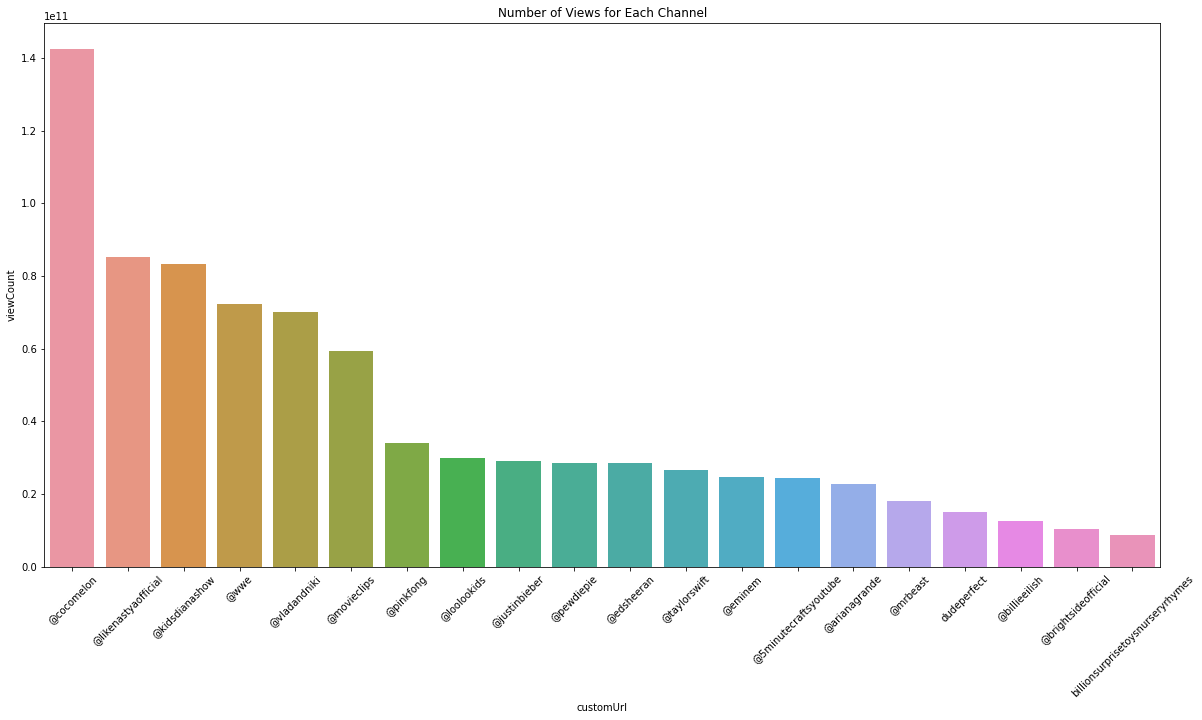

In [17]:
# plot the number of views for each channel
plt.figure(figsize=(20,10))
sns.barplot(x='customUrl', y='viewCount', data=df) 
plt.xticks(rotation=45)
plt.title('Number of Views for Each Channel')
plt.show()

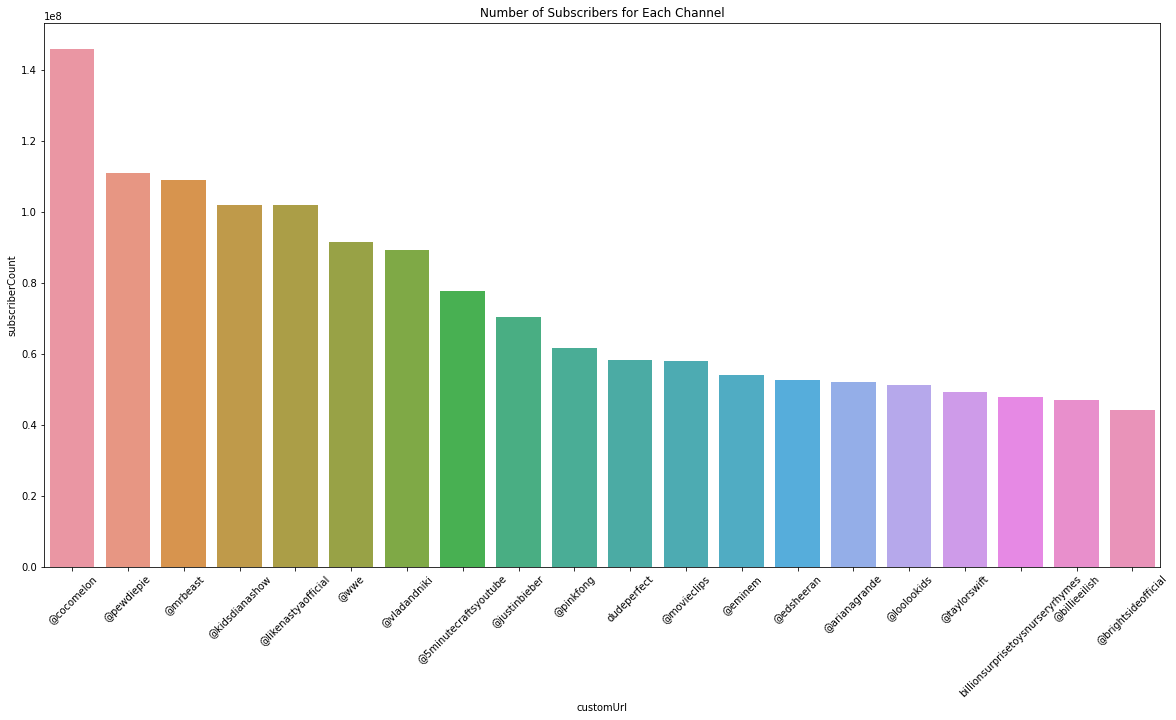

In [18]:
# plot the number of subscribers for each channel, ordered by number of subscribers
plt.figure(figsize=(20,10))
sns.barplot(x='customUrl', y='subscriberCount', data=df.sort_values('subscriberCount', ascending=False))
plt.xticks(rotation=45)
plt.title('Number of Subscribers for Each Channel')
plt.show()